In [6]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..')))

import torch
from torch.utils.data import DataLoader
from data import DatasetEEG, DatasetEEGTorch
from data.preprocessing import normalize_signals
from data.preprocessing import create_dataset_from_windows, crop_signals
from helpers.model_utils import plot_training_metrics, count_model_parameters, train_model


## Data augmentation
In questo esempio faccio data augmentation sul mio dataset, creando vari samples con una finestra mobile a partire dallo stesso trial. In questo modo posso testare le varie architetture nel caso migliore possibile e minimizzando il rischio di overfitting

Carico il dataset di training, faccio la data augmentation e poi successivamente lo divido in training e validation

In [5]:
# Carico il dataset per il training
dataset_bci = DatasetEEG.load('../dataset_bci/processed/include_rejected/01_Training.dataset')

# Normalizzo
normalize_signals(dataset_bci)

# Faccio data augmentation
dataset_bci = create_dataset_from_windows(dataset_bci, time_start=0.5, time_end=4,
                                          time_window=2, fs=250, shift=10)

# Divido in training e validation
dataset_training, dataset_validation = dataset_bci.split_dataset(validation_size=0.2)

# Mostro le caratteristiche
print(dataset_training)
print(dataset_validation)

# Altre caratteristiche dei dati che serviranno successivamente
fs = 250
channels = 22
num_timepoints = dataset_bci.num_timepoints


num_trials               :  8755
num_channels             :  22
num_timepoints           :  500
labels_type              :  single_label
labels_format            :  int
subject                  :  1
fs                       :  250

num_trials               :  2189
num_channels             :  22
num_timepoints           :  500
labels_type              :  single_label
labels_format            :  int
subject                  :  1
fs                       :  250



In [7]:
# Carico il dataset di test e su questo non faccio ovviamente data augmentation, ma solo un crop
dataset_bci_test = DatasetEEG.load('../dataset_bci/processed/include_rejected/01_Test.dataset')

normalize_signals(dataset_bci_test)
crop_signals(dataset_bci_test, t_min=0.5, t_max=2.5)

print(dataset_bci_test)


num_trials               :  288
num_channels             :  22
num_timepoints           :  500
labels_type              :  single_label
labels_format            :  int
subject                  :  1
fs                       :  250



In [8]:
# Creo i dataset e i dataloader per pytorch
dataset_training_pytorch = DatasetEEGTorch(dataset_training)
dataset_validation_pytorch = DatasetEEGTorch(dataset_validation)
dataset_test_pytorch = DatasetEEGTorch(dataset_bci_test)

# Se è presente la GPU sfrutto quella e sposto i dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset_training_pytorch.to_device(device)
dataset_validation_pytorch.to_device(device)
dataset_test_pytorch.to_device(device)

# Creo i dataloader
batch_size = 32
dataloader_training = DataLoader(dataset_training_pytorch, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(dataset_validation_pytorch, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test_pytorch, batch_size=batch_size, shuffle=False)

cuda


/home/nuzzi/Projects/EEG_Pipeline/EEG-ANN-Pipeline/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## EEGNet

In [9]:
from models import EEGNet

model = EEGNet(num_classes=4, channels=channels)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')


Il modello ha 1456 parametri


  0%|          | 0/100 [00:00<?, ?it/s]/home/nuzzi/Projects/EEG_Pipeline/EEG-ANN-Pipeline/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 100/100 [02:46<00:00,  1.67s/it, loss=0.153, accuracy=0.932]


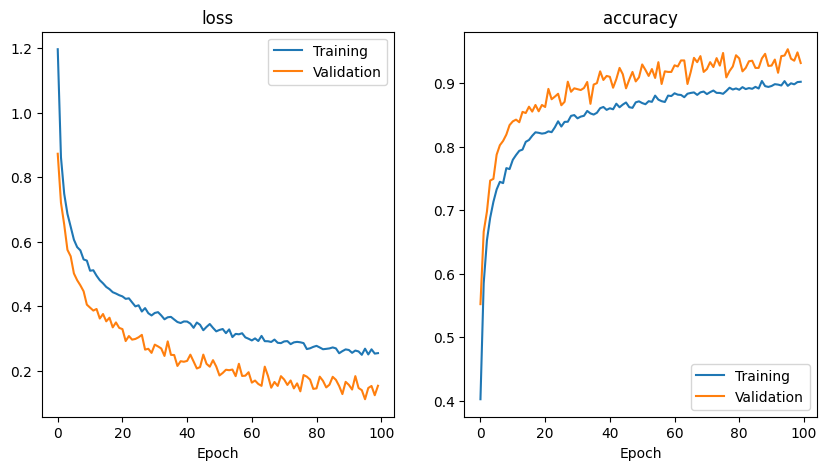

In [10]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training, dataloader_validation, epochs=100)

# Plot risultati del training
plot_training_metrics(metrics)

In [11]:
# Setto il modello in modalità eval (non training)
model.eval()

# Inizializzo per accumulare poi in ogni batch
accuracy = 0

# Ciclo sul test set
for i, batch in enumerate(dataloader_test):

    x, y = batch
    y_pred = model.predict(x)

    # Calcolo l'accuratezza
    accuracy += torch.sum(y_pred == y).item()

accuracy /= len(dataloader_test.dataset)

print(f'Accuratezza sul test set = {accuracy:.4f}')


Accuratezza sul test set = 0.7882


## Mio modello multi-scala

In [12]:
from models import EEGNetMultiscale

model = EEGNetMultiscale(num_classes=4, channels=channels, fs=250)
model.to(device)

print(count_model_parameters(model))


49130


100%|██████████| 100/100 [06:28<00:00,  3.88s/it, loss=0.0759, accuracy=0.961]


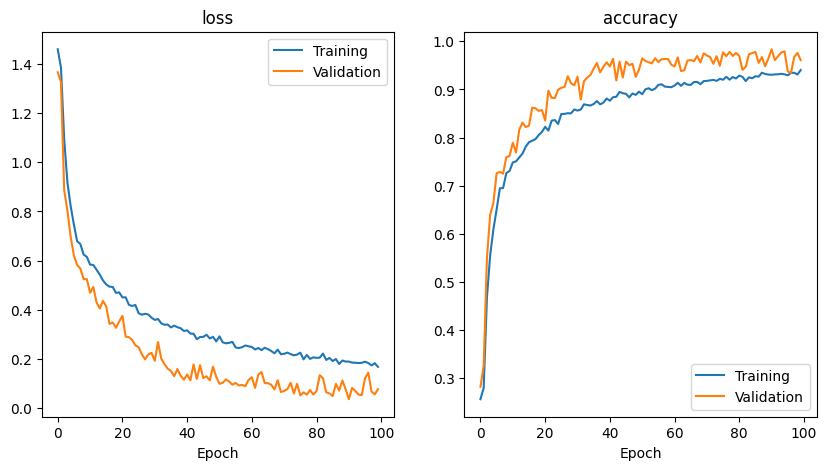

In [13]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training, dataloader_validation, epochs=100)

# Plot risultati del training
plot_training_metrics(metrics)

In [14]:
# Setto il modello in modalità eval (non training)
model.eval()

# Inizializzo per accumulare poi in ogni batch
accuracy = 0

# Ciclo sul test set
for i, batch in enumerate(dataloader_test):

    x, y = batch
    y_pred = model.predict(x)

    # Calcolo l'accuratezza
    accuracy += torch.sum(y_pred == y).item()

accuracy /= len(dataloader_test.dataset)

print(f'Accuratezza sul test set = {accuracy:.4f}')


Accuratezza sul test set = 0.7361
